### Carregando os Dados

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

file_path = "dados/Sample - Superstore.csv"

#Lendo o arquivo com a codificação em latin1, utf 8 tava dando muitos erros....
df = pd.read_csv(file_path, encoding="latin1")

#Exibindo as 5 primeiras linhas do dataset
#df.head()



### Preparação dos Dados

In [2]:
#Verificando se há valores ausentes
missing_values = df.isnull().sum()

#Convertendo as colunas que são de data para a data no formato correto
df['Order Date'] = pd.to_datetime(df['Order Date'], format="%m/%d/%Y")
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format="%m/%d/%Y")

#Criando as colunas derivadas de data em inglês (estuda inglês mano!)
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Month Name'] = df['Order Date'].dt.strftime('%B')
df['Weekday'] = df['Order Date'].dt.day_name()
df['Profit per Sale'] = df['Profit'] / df['Quantity']
df['Sales per Unit'] = df['Sales'] / df['Quantity']

#Resumo final dos dados
prepared_info = {
    "Dimensão do dataset": df.shape,
    "Valores ausentes por coluna": missing_values[missing_values > 0],
    "Tipos de dados (amostragem)": df.dtypes.head(10)
}

prepared_info


{'Dimensão do dataset': (9994, 27),
 'Valores ausentes por coluna': Series([], dtype: int64),
 'Tipos de dados (amostragem)': Row ID                    int64
 Order ID                 object
 Order Date       datetime64[ns]
 Ship Date        datetime64[ns]
 Ship Mode                object
 Customer ID              object
 Customer Name            object
 Segment                  object
 Country                  object
 City                     object
 dtype: object}

## Análise Exploratória dos Dados

### Visão Geral

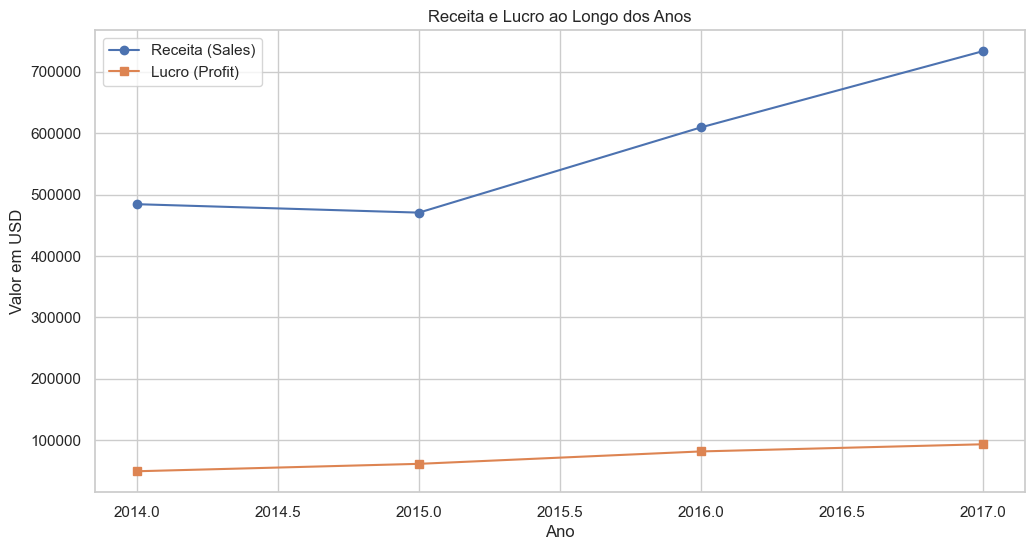

In [ ]:
#Estilo do gráfico
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

#Criando a Receita e lucro por ano
year_summary = df.groupby("Year")[["Sales", "Profit"]].sum().reset_index()

#Receita e Lucro ao longo dos anos
plt.plot(year_summary["Year"], year_summary["Sales"], marker='o', label='Receita (Sales)')
plt.plot(year_summary["Year"], year_summary["Profit"], marker='s', label='Lucro (Profit)')
plt.title("Receita e Lucro ao Longo dos Anos")
plt.xlabel("Ano")
plt.ylabel("Valor em USD")
plt.legend()
plt.grid(True)
plt.show()

### Categorias, Regiões e Clientes

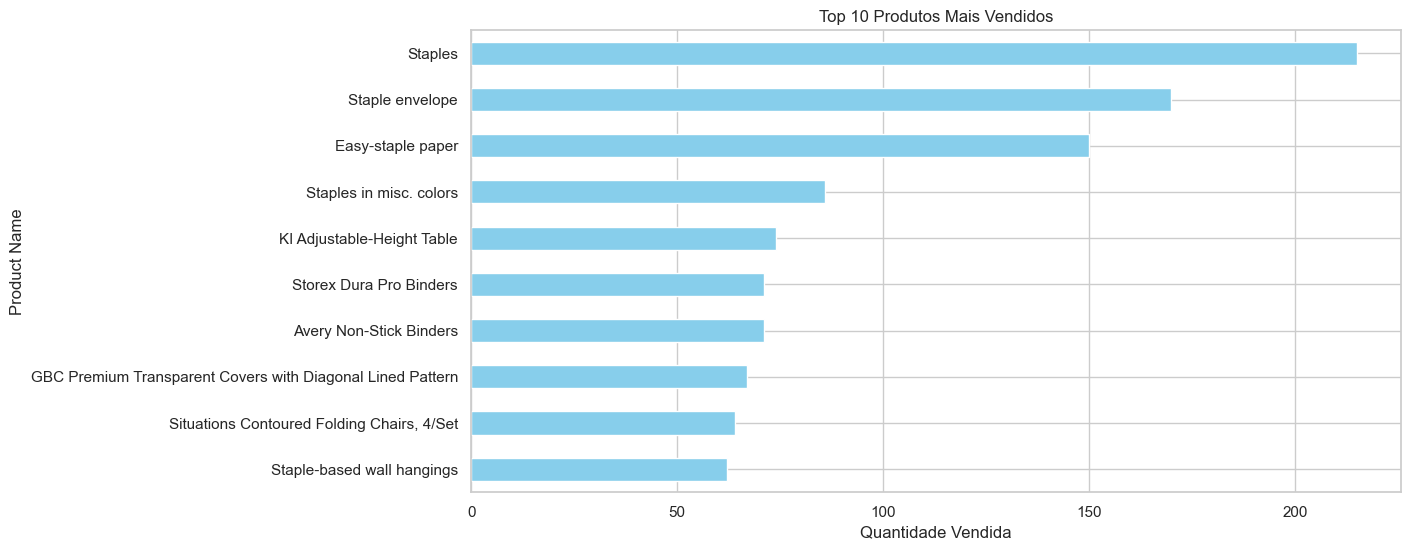

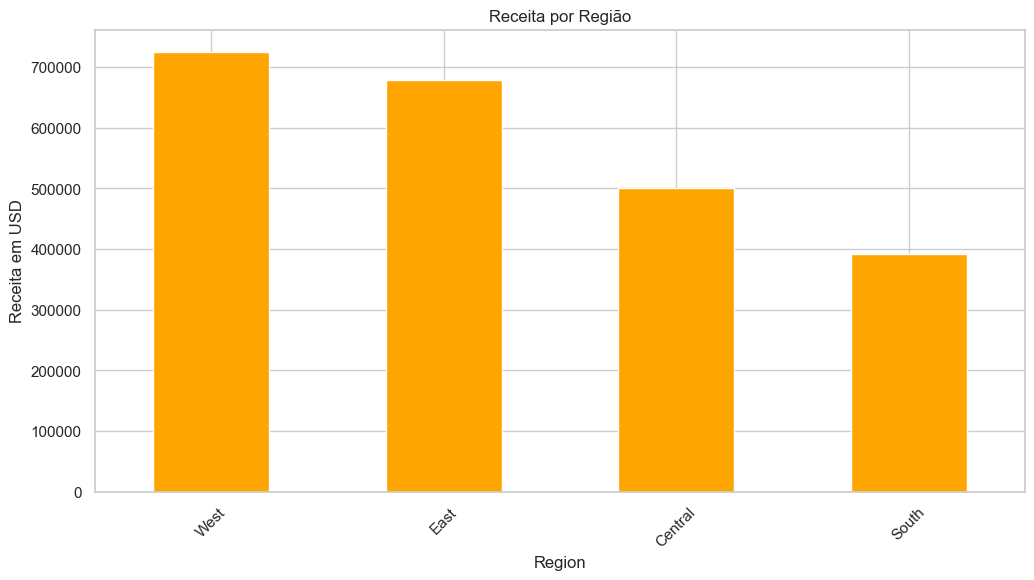

In [ ]:
#Criando o Top 10 produtos mais vendidos
top_products = df.groupby("Product Name")["Quantity"].sum().sort_values(ascending=False).head(10)

#Top produtos
top_products.plot(kind="barh", color="skyblue")
plt.title("Top 10 Produtos Mais Vendidos")
plt.xlabel("Quantidade Vendida")
plt.gca().invert_yaxis()
plt.show()

#Criando a Receita por região
region_sales = df.groupby("Region")["Sales"].sum().sort_values(ascending=False)

#Receita por Região
region_sales.plot(kind="bar", color="orange")
plt.title("Receita por Região")
plt.ylabel("Receita em USD")
plt.xticks(rotation=45)
plt.show()


### Sazonalidade

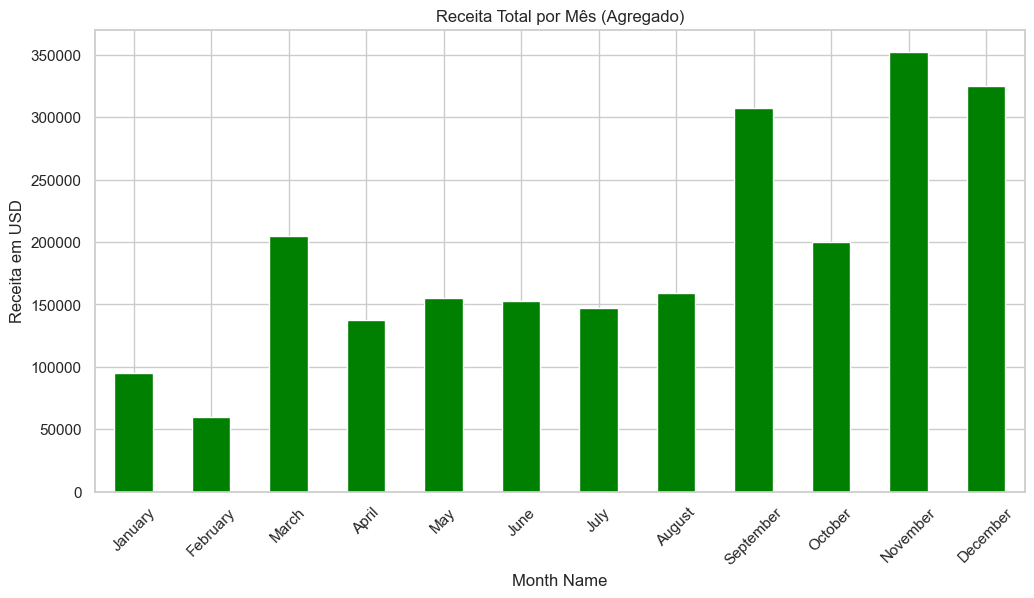

In [ ]:
#Criando a Receita por mês agregado
monthly_sales = df.groupby("Month Name")["Sales"].sum()
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales = monthly_sales.loc[month_order]

#Receita por mês
monthly_sales.plot(kind="bar", color="green")
plt.title("Receita Total por Mês (Agregado)")
plt.ylabel("Receita em USD")
plt.xticks(rotation=45)
plt.show()


### Mapa de calor por dia da semana

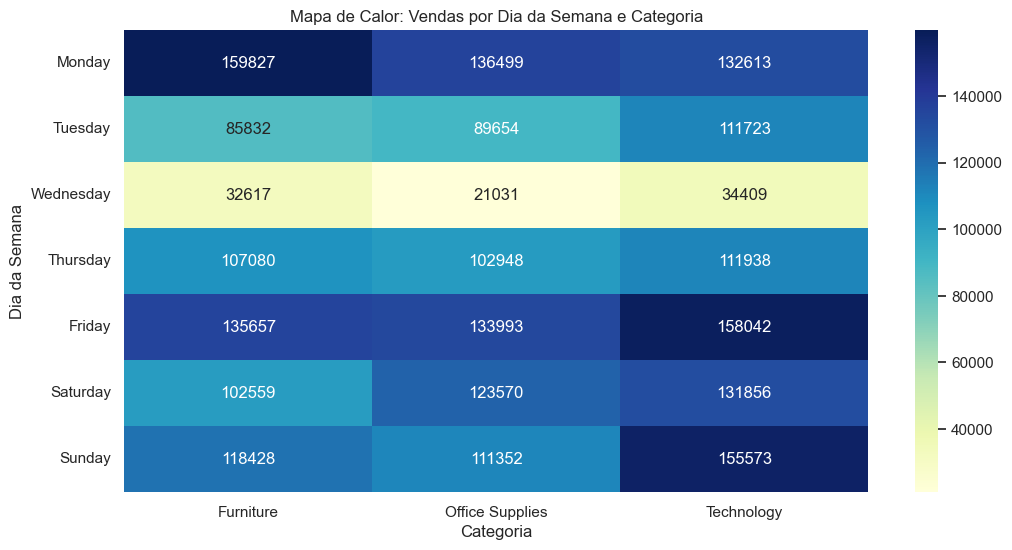

In [ ]:
#Fazendo o agrupamento por dia da semana e categoria
heatmap_data = df.groupby(["Weekday", "Category"])["Sales"].sum().unstack().fillna(0)

#Reordenar os dias da semana em inglês
dias_semana = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(dias_semana)

#Mapa de calor
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Mapa de Calor: Vendas por Dia da Semana e Categoria")
plt.ylabel("Dia da Semana")
plt.xlabel("Categoria")
plt.show()


## RFM 

### Segmentação RFM

In [ ]:
import datetime as dt

#Usando a última data do dataset como minha referência
ref_date = df['Order Date'].max() + pd.Timedelta(days=1)

#Agrupando por id dos clientes
rfm = df.groupby("Customer ID").agg({
    "Order Date": lambda x: (ref_date - x.max()).days,  # Recência
    "Order ID": "nunique",                              # Frequência
    "Sales": "sum"                                      # Valor Monetário
}).reset_index()

#Renomeando as colunas
rfm.columns = ["Customer ID", "Recency", "Frequency", "Monetary"]

#Adicionando o score (1 a 4) por quartil
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

#Combinando os scores em um único segmento
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)


def segmentar_cliente(score):
    if score >= 9:
        return 'VIP'
    elif score >= 6:
        return 'Potencial'
    else:
        return 'Inativo'

rfm['Segmento'] = rfm['RFM_Score'].apply(segmentar_cliente)

rfm.head()


,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score,Segmento
0,AA-10315,185,5,5563.560,1,1,4,114,6,Potencial
1,AA-10375,20,9,1056.390,4,4,1,441,9,VIP
2,AA-10480,260,4,1790.512,1,1,2,112,4,Inativo
3,AA-10645,56,6,5086.935,3,2,4,324,9,VIP
4,AB-10015,416,3,886.156,1,1,1,111,3,Inativo


### Distribuição de scores R F M

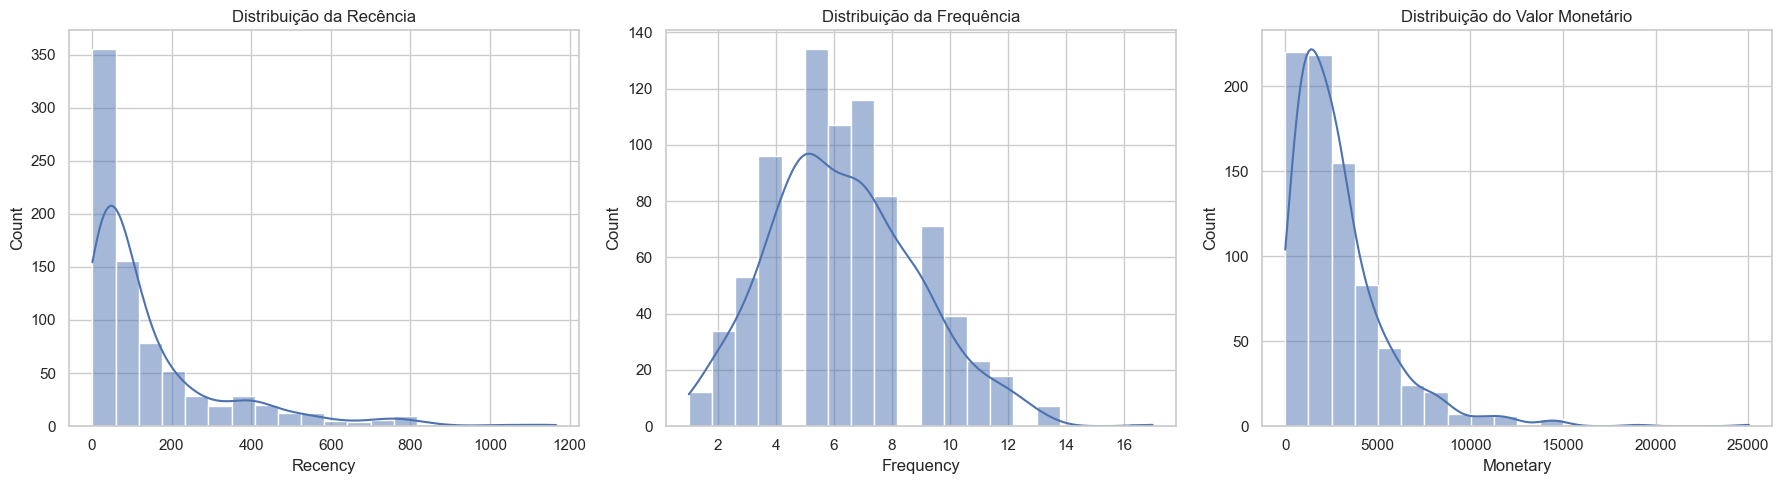

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(rfm['Recency'], bins=20, kde=True, ax=axs[0])
axs[0].set_title('Distribuição da Recência')

sns.histplot(rfm['Frequency'], bins=20, kde=True, ax=axs[1])
axs[1].set_title('Distribuição da Frequência')

sns.histplot(rfm['Monetary'], bins=20, kde=True, ax=axs[2])
axs[2].set_title('Distribuição do Valor Monetário')

plt.tight_layout()
plt.show()


### Tabela com os principais clientes (Top 10)

In [9]:
top_clientes = rfm.sort_values(by="Monetary", ascending=False).head(10)
print(top_clientes[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Segmento']])


    Customer ID  Recency  Frequency   Monetary   Segmento
700    SM-20320       80          5  25043.050  Potencial
741    TC-20980      400          5  19052.218  Potencial
621    RB-19360       97          6  15117.339        VIP
730    TA-21385       70          4  14595.620  Potencial
6      AB-10105       42         10  14473.571        VIP
434    KL-16645       48         12  14175.229        VIP
669    SC-20095      350          9  14142.334        VIP
327    HL-15040       44          6  12873.298        VIP
683    SE-20110       10         11  12209.438        VIP
131    CC-12370       44          5  12129.072        VIP


## Sazonalidade e Séries Temporais

### Preparando os Dados

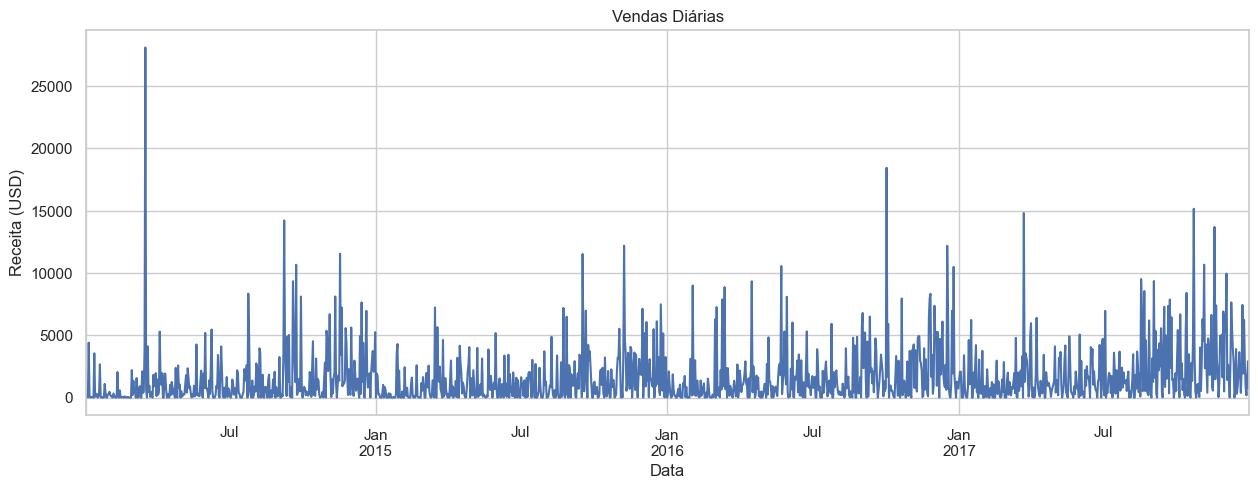

In [ ]:
#Agrupando pela data (vendas diárias)
sales_daily = df.groupby("Order Date")["Sales"].sum().asfreq('D').fillna(0)

#Série temporal
sales_daily.plot(figsize=(15, 5), title="Vendas Diárias")
plt.xlabel("Data")
plt.ylabel("Receita (USD)")
plt.show()


### Decomposição

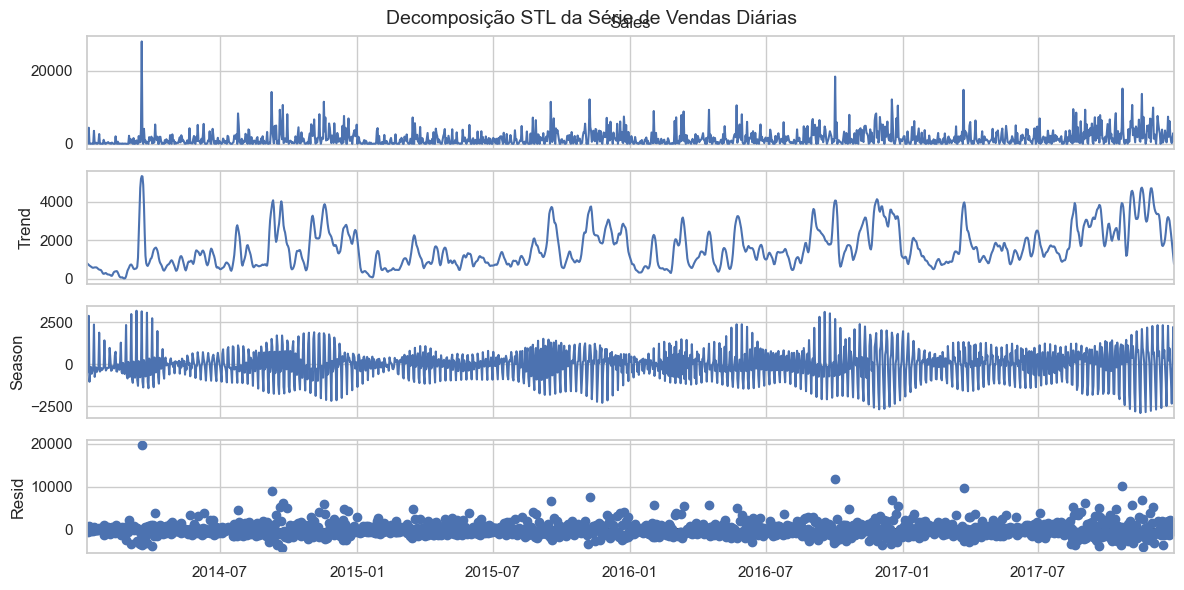

In [ ]:
from statsmodels.tsa.seasonal import STL

#Aplicando o STL (Seasonal-Trend-Loess)
stl = STL(sales_daily, seasonal=13)
result = stl.fit()

#Plotando os componentes
result.plot()
plt.suptitle("Decomposição STL da Série de Vendas Diárias", fontsize=14)
plt.show()


### Autocorrelação

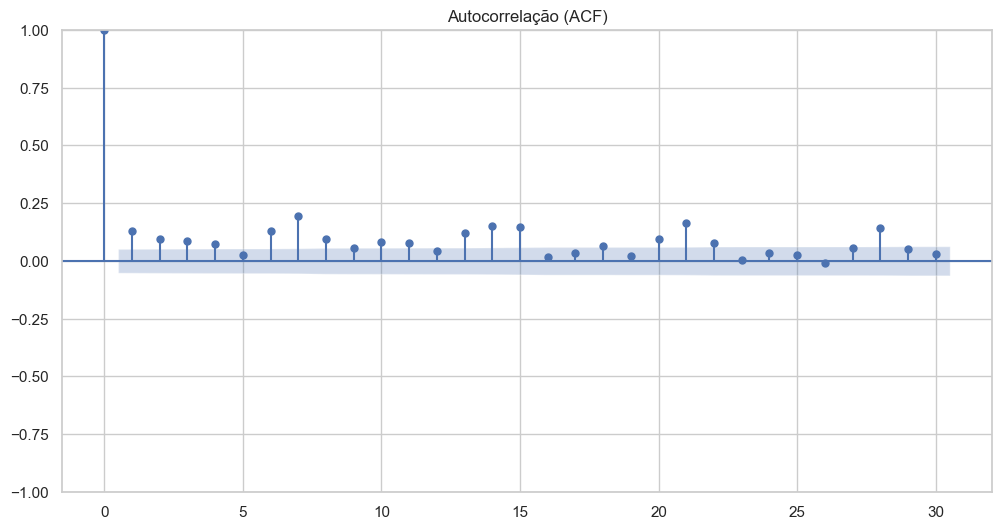

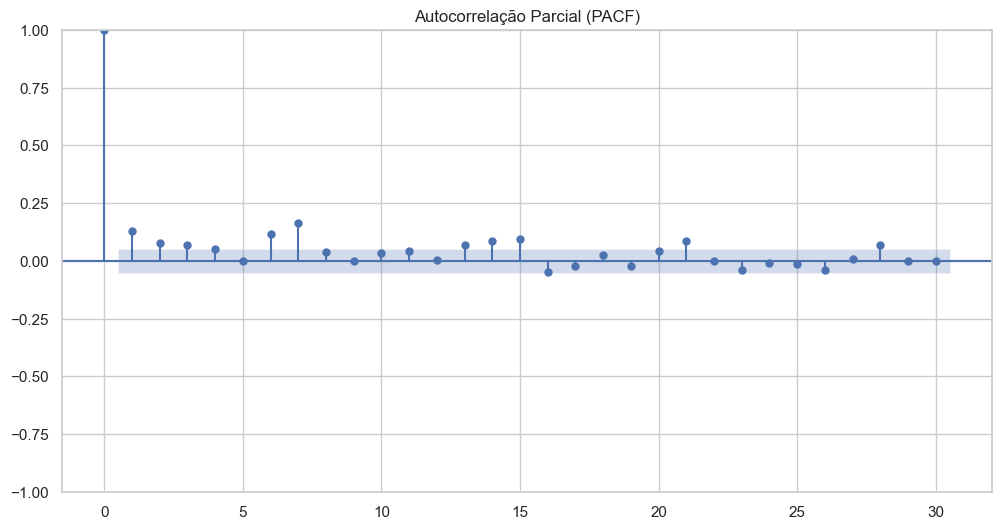

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Criando a autocorrelação
plot_acf(sales_daily, lags=30)
plt.title("Autocorrelação (ACF)")
plt.show()

#Criando a autocorrelação parcial
plot_pacf(sales_daily, lags=30)
plt.title("Autocorrelação Parcial (PACF)")
plt.show()


##  Previsão de Vendas Futuras

### Preparando os dados para receber o modelo SARIMA

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np

#Reutilizando a série de vendas diárias
sales_daily = df.groupby("Order Date")["Sales"].sum().asfreq("D").fillna(0)

#Dividindo em treino/teste (últimos 90 dias como teste)
train = sales_daily[:-90]
test = sales_daily[-90:]


### Treinando o modelo

In [ ]:
#Treinando modelo SARIMA 
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
model_fit = model.fit(disp=False)

#Prevendo no período de teste
pred = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

#Avaliando os erros (RMSE)
rmse = np.sqrt(mean_squared_error(test, pred))
print(f"RMSE no período de teste: {rmse:.2f}")


RMSE no período de teste: 2957.98


### Visualizando a previsão

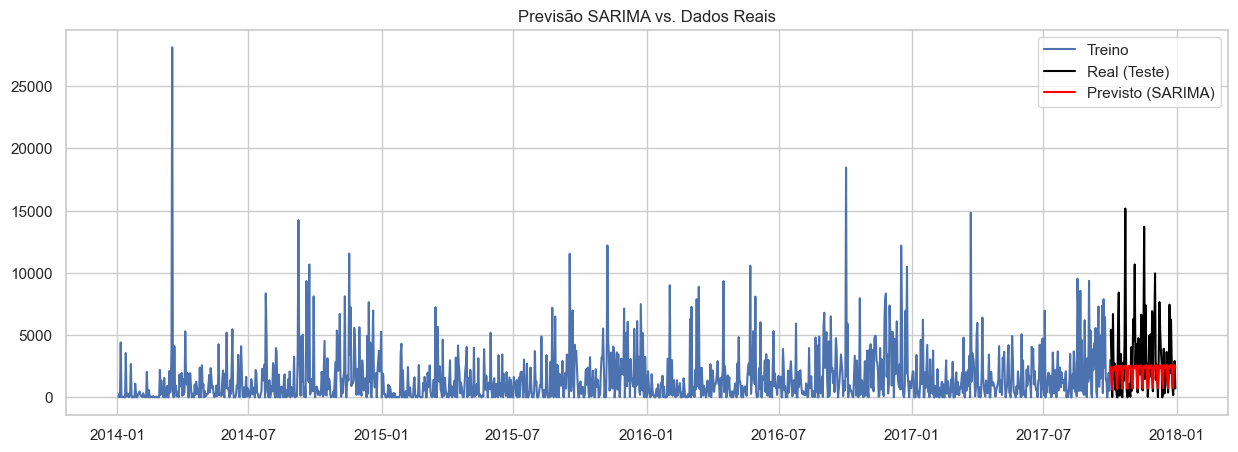

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train, label="Treino")
plt.plot(test.index, test, label="Real (Teste)", color="black")
plt.plot(pred.index, pred, label="Previsto (SARIMA)", color="red")
plt.title("Previsão SARIMA vs. Dados Reais")
plt.legend()
plt.show()


### Previsão com base nos dias escolhidos para prevê

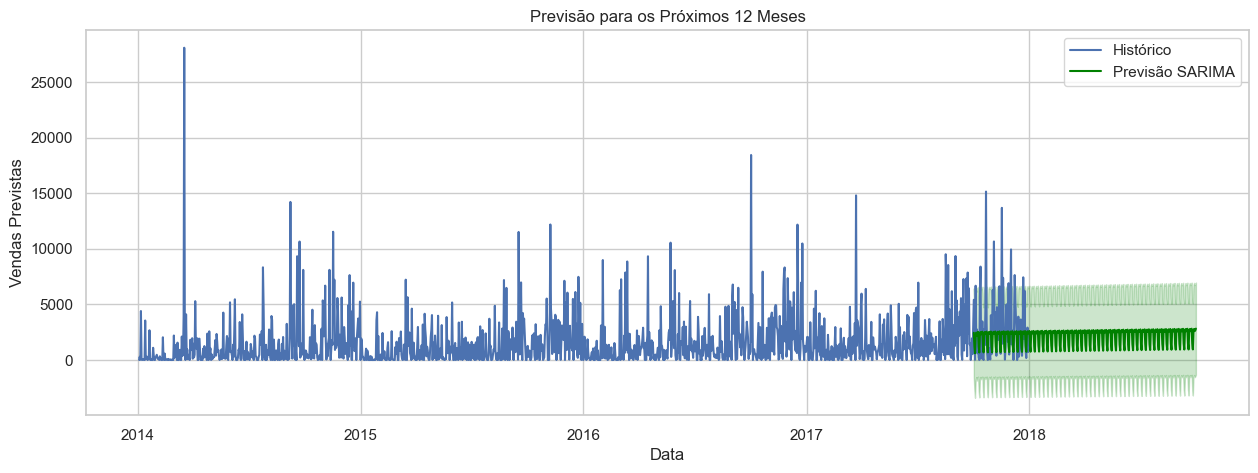

In [ ]:
#Número de dias para prever (modifique se quiser meu caro amigo(a))
dias_3m = 90
dias_6m = 180
dias_12m = 365

#Previsão para os próximos 365 dias (com intervalo)
future_forecast = model_fit.get_forecast(steps=dias_12m)
forecast_mean = future_forecast.predicted_mean
conf_int = future_forecast.conf_int()


plt.figure(figsize=(15, 5))
plt.plot(sales_daily, label="Histórico")
plt.plot(forecast_mean, label="Previsão SARIMA", color="green")
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title("Previsão para os Próximos 12 Meses")
plt.xlabel("Data")
plt.ylabel("Vendas Previstas")
plt.legend()
plt.show()


## Análise de Desempenho dos Vendedores

### Métricas por Vendedor

In [ ]:
vendas_segmento = df.groupby("Segment").agg({
    "Sales": "sum",
    "Profit": "sum",
    "Order ID": "nunique"
}).reset_index()

vendas_segmento["Ticket Médio"] = vendas_segmento["Sales"] / vendas_segmento["Order ID"]
vendas_segmento


,Segment,Sales,Profit,Order ID,Ticket Médio
0,Consumer,1.161401e+06,134119.2092,2586,449.111116
1,Corporate,7.061464e+05,91979.1340,1514,466.411075
2,Home Office,4.296531e+05,60298.6785,909,472.665730


### Performance dos Vendedores

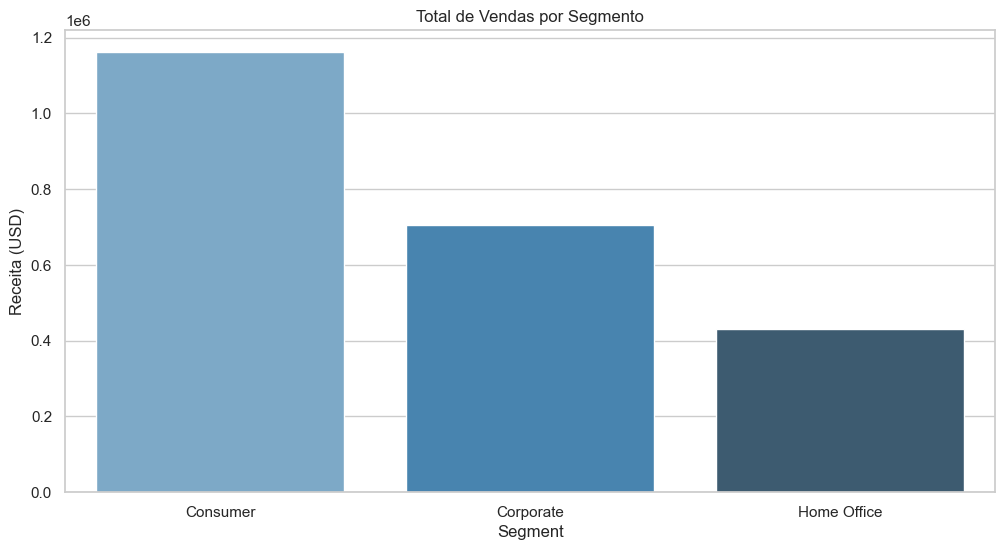

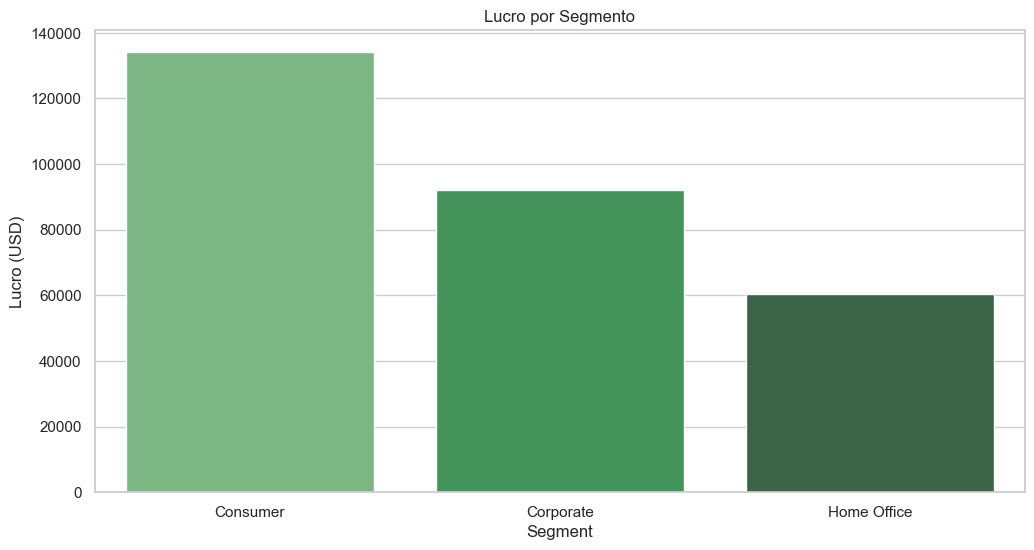

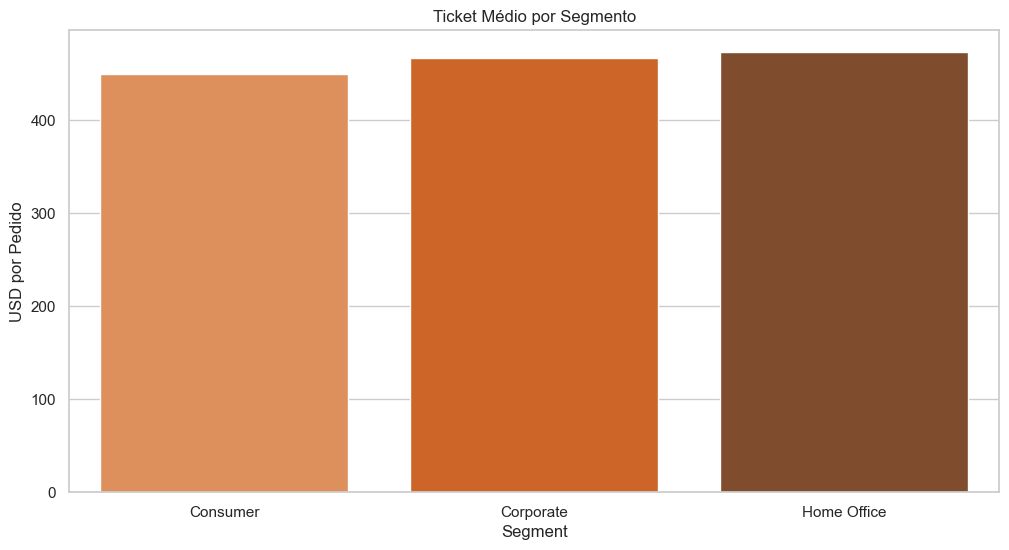

In [ ]:
#Receita por Segmento
sns.barplot(data=vendas_segmento, x="Segment", y="Sales", palette="Blues_d")
plt.title("Total de Vendas por Segmento")
plt.ylabel("Receita (USD)")
plt.show()

#Lucro por Segmento
sns.barplot(data=vendas_segmento, x="Segment", y="Profit", palette="Greens_d")
plt.title("Lucro por Segmento")
plt.ylabel("Lucro (USD)")
plt.show()

#Ticket médio
sns.barplot(data=vendas_segmento, x="Segment", y="Ticket Médio", palette="Oranges_d")
plt.title("Ticket Médio por Segmento")
plt.ylabel("USD por Pedido")
plt.show()


### Análise por Regiões e Categoria

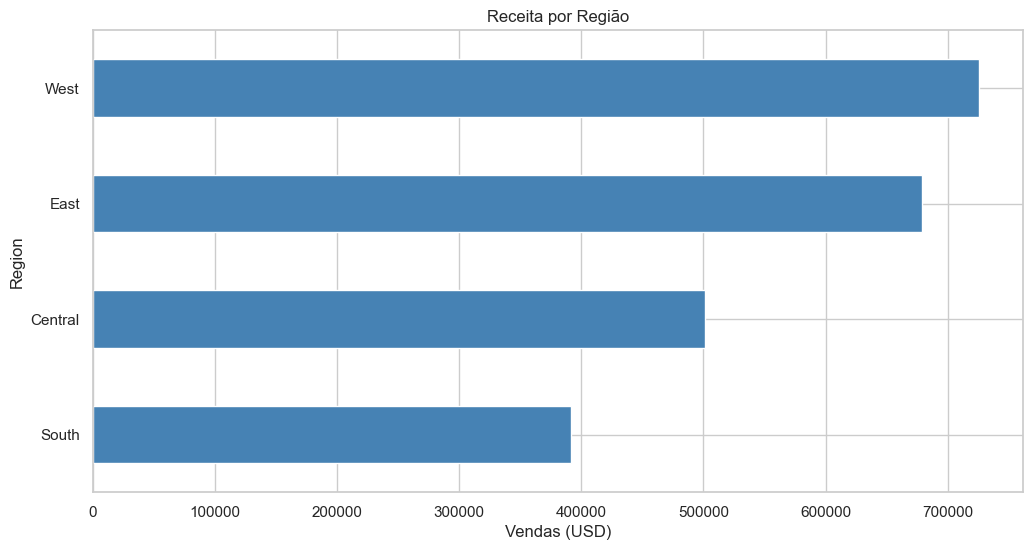

In [ ]:
#Ranking de receita por região
region_sales = df.groupby("Region")["Sales"].sum().sort_values(ascending=False)


region_sales.plot(kind='barh', color='steelblue')
plt.title("Receita por Região")
plt.xlabel("Vendas (USD)")
plt.gca().invert_yaxis()
plt.show()
